In [8]:
import nltk
import torch
import matplotlib.pyplot as plt
from rouge_score import rouge_scorer
from transformers import GPT2LMHeadModel, GPT2Tokenizer #Hugging Face’s library for pre-trained models
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from rouge import Rouge # Metric to evaluate how good the generated text is compared to reference
from nltk.translate.meteor_score import meteor_score
from transformers import pipeline
from sklearn.metrics import f1_score
from bert_score import BERTScorer
import numpy as np
import pandas as pd


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/mac/Documents/Text_Conversational_102203514/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/mac/Documents/Text_Conversational_102203514/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/mac/Documents/Text_Conversational_102203514/.venv/lib/python3.11/

In [123]:
# list of pre-trained models from hugging face
conversational_models = [
    "microsoft/DialoGPT-medium",
    "Pi3141/DialoGPT-medium-elon-2",
    "textattack/roberta-base-CoLA",
    "microsoft/DialoGPT-large",
    "microsoft/DialoGPT-small",
    "satvikag/chatbot"
]

# list of aquestions to evaluate the model 
prompts = [
    "How does photosynthesis work?",
    "Tell me a joke.",
    "What is the capital of France?",
    "Explain the theory of relativity.",
    "Any book recommendations?"
]
# Ideal answer to the promts. these are used to compare models response
references = [
    "Photosynthesis is the process by which green plants and some other organisms use sunlight to synthesize foods with the help of chlorophyll.",
    "Why did the chicken cross the road? To get to the other side!",
    "The capital of France is Paris.",
    "The theory of relativity, formulated by Albert Einstein, describes the relationships between space, time, and gravity.",
    "It depends on your interests. What genres do you like?"
]

In [124]:
# loading pre-traied model and tokenizer(break text into pieces); model can understand 
def initialize_model_and_tokenizer(model_name):
    model = GPT2LMHeadModel.from_pretrained(model_name)
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    return model, tokenizer

# takes prompt and convert text to numbers(tokens) and the model predict the next word to response 
def generate_response(prompt, model, tokenizer, max_length=50, temperature=0.7):
    input_ids = tokenizer.encode(prompt, return_tensors="pt")
    output = model.generate(input_ids, max_length=max_length, temperature=temperature, num_beams=5)
    generated_response = tokenizer.decode(output[0], skip_special_tokens=True)
    return generated_response

# compare the models response and reference text 
'''
Rouge-N: check the overlap of words
Rouge-L:  check the overlap of sentence
'''
def calculate_rouge(references, candidate):
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    scores = scorer.score(references, candidate)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure
    return rouge1, rouge2, rougeL

# Measures how "confused" the model is when generating text (lower = better).
def calculate_perplexity(model, tokenizer, response):
    input_ids = tokenizer.encode(response, return_tensors="pt")
    loss = model(input_ids, labels=input_ids).loss
    return torch.exp(loss).item()

def calculate_f1(reference, candidate):
    reference_set = set(reference.split())
    candidate_set = set(candidate.split())

    precision = len(reference_set.intersection(candidate_set)) / len(candidate_set)
    recall = len(reference_set.intersection(candidate_set)) / len(reference_set)

    f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return f1
'''
F1-score : how well the models response mathches the reference
Precision : % of words in the model’s response that are correct.
Recall : % of correct words from the reference that the model included.
'''

'\nF1-score : how well the models response mathches the reference\nPrecision : % of words in the model’s response that are correct.\nRecall : % of correct words from the reference that the model included.\n'

In [125]:
results = dict()

In [127]:
for model_name in conversational_models:
    model, tokenizer = initialize_model_and_tokenizer(model_name)
    bleu_scores = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    f1_scores = []
    response_lengths = []
    
    grammaticality_scores = []
    bert_scores = []
    perplexity_scores = []

    for prompt, reference in zip(prompts, references):
        model_response = generate_response(prompt, model, tokenizer)
       
        rouge1, rouge2, rougeL = calculate_rouge(reference, model_response)
        rouge1_scores.append(rouge1)
        rouge2_scores.append(rouge2)
        rougeL_scores.append(rougeL)
        
        # 3. Perplexity
        perplexity = calculate_perplexity(model, tokenizer, model_response)
        perplexity_scores.append(perplexity)
       
        f1 = calculate_f1(reference, model_response)
        f1_scores.append(f1)

        response_lengths.append(len(model_response.split()))

    avg_rouge1_score = sum(rouge1_scores) / len(rouge1_scores)
    avg_rouge2_score = sum(rouge2_scores) / len(rouge2_scores)
    avg_rougeL_score = sum(rougeL_scores) / len(rougeL_scores)
    avg_f1_score = sum(f1_scores)/len(f1_scores)
    avg_response_length = sum(response_lengths) / len(response_lengths)
    
    avg_perplexity = sum(perplexity_scores) / len(perplexity_scores)

    # Stores average scores for each model.
    results[model_name] = {
            "ROUGE-1": avg_rouge1_score,
            "ROUGE-2": avg_rouge2_score,
            "ROUGE-L": avg_rougeL_score,
            "F1" : avg_f1_score,
            "Response Length": avg_response_length,
            "Perplexity": avg_perplexity,
        }

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

In [129]:
# Prints the results to compare models side-by-side.
for model_name, scores in results.items():
    print(f"Model: {model_name}")
    print(f"ROUGE-1 Score: {scores['ROUGE-1']:.4f}")
    print(f"ROUGE-2 Score: {scores['ROUGE-2']:.4f}")
    print(f"ROUGE-L Score: {scores['ROUGE-L']:.4f}")
    print(f"F1 Score: {scores['F1']:.4f}")
    print(f"Perplexity: {scores['Perplexity']:.4f}")
    print(f"Average Response Length: {scores['Response Length']:.3f} \n")
    

Model: microsoft/DialoGPT-medium
ROUGE-1 Score: 0.1097
ROUGE-2 Score: 0.0533
ROUGE-L Score: 0.1097
F1 Score: 0.1612
Perplexity: 4169.5243
Average Response Length: 16.600 

Model: Pi3141/DialoGPT-medium-elon-2
ROUGE-1 Score: 0.1238
ROUGE-2 Score: 0.0786
ROUGE-L Score: 0.1136
F1 Score: 0.1007
Perplexity: 434.5255
Average Response Length: 11.400 

Model: textattack/roberta-base-CoLA
ROUGE-1 Score: 0.0895
ROUGE-2 Score: 0.0594
ROUGE-L Score: 0.0812
F1 Score: 0.1272
Perplexity: 4792.1502
Average Response Length: 40.800 

Model: microsoft/DialoGPT-large
ROUGE-1 Score: 0.1889
ROUGE-2 Score: 0.1026
ROUGE-L Score: 0.1771
F1 Score: 0.2364
Perplexity: 27.7805
Average Response Length: 30.400 

Model: microsoft/DialoGPT-small
ROUGE-1 Score: 0.2278
ROUGE-2 Score: 0.1564
ROUGE-L Score: 0.1944
F1 Score: 0.1364
Perplexity: 30942.5613
Average Response Length: 6.800 

Model: satvikag/chatbot
ROUGE-1 Score: 0.2582
ROUGE-2 Score: 0.1832
ROUGE-L Score: 0.2249
F1 Score: 0.1571
Perplexity: 961.2183
Average Re

In [130]:
results_df = pd.DataFrame(results).T
results_df

,ROUGE-1,ROUGE-2,ROUGE-L,F1,Response Length,Perplexity
microsoft/DialoGPT-medium,0.109660,0.053268,0.109660,0.161212,16.6,4169.524320
Pi3141/DialoGPT-medium-elon-2,0.123810,0.078586,0.113553,0.100699,11.4,434.525475
textattack/roberta-base-CoLA,0.089486,0.059420,0.081153,0.127174,40.8,4792.150195
microsoft/DialoGPT-large,0.188871,0.102579,0.177107,0.236384,30.4,27.780534
microsoft/DialoGPT-small,0.227766,0.156364,0.194432,0.136364,6.8,30942.561339
satvikag/chatbot,0.258242,0.183158,0.224908,0.157143,4.4,961.218251


In [131]:
results_df.to_csv('results.csv')

In [4]:
! pip install Topsis-Sumit-Garg-102203514



[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip install --upgrade pip


In [6]:
! python -m Topsis_Sumit_Garg_102203514 "results.csv" "1,1,1,1,1,1" '+,-,-,+,+,-' "final.csv"

Results saved to final.csv


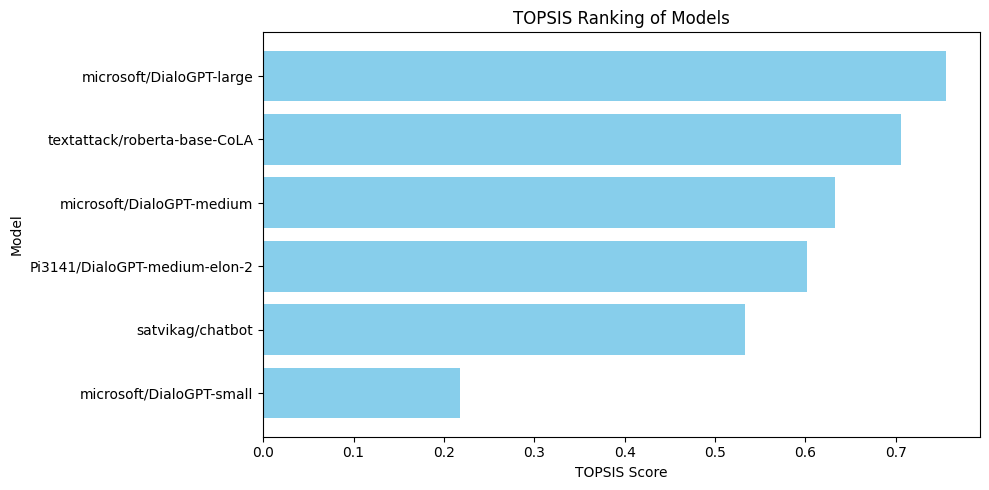

In [133]:
final = pd.read_csv('final.csv')  # Replace with your CSV path
# Sort the DataFrame by TOPSIS Score (ascending to show highest at top after inversion)
final = final.sort_values('Topsis Score', ascending=False)
plt.figure(figsize=(10, 5))
plt.barh(final.iloc[:, 0], final['Topsis Score'], color='skyblue')
plt.xlabel('TOPSIS Score')
plt.ylabel('Model')
plt.title('TOPSIS Ranking of Models')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig(f'topsis_models_comparison.png')
plt.show()

In [9]:
metrics = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L', 'Response Length', 'Perplexity']

custom_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEEAD']  # Add more colors as needed

for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(final.index, final[metric], color=custom_colors)
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'{metric} Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{metric}_comparison.png')
    plt.show()


NameError: name 'final' is not defined

<Figure size 1000x600 with 0 Axes>